# 1. Config the Environment

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from datetime import datetime


print(f'python version: {sys.version}')
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'numpy version: {np.__version__}')

python version: 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
tensorflow version: 2.9.1
keras version: 2.9.0
numpy version: 1.22.4


In [2]:
def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        elif minor_version >= 9:

            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

print ("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())

We are using Tensorflow version 2.9.1
MKL enabled : True


In [3]:
from art.attacks.evasion import SquareAttack
from art.estimators.classification import TensorFlowV2Classifier

In [4]:
#strategy = tf.distribute.MirroredStrategy()

In [5]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [6]:
#x_train, y_train = tf.cast(x_train, tf.float32), tf.cast(y_train, tf.float32)

In [7]:
min_ = 0
max_ = 1

In [8]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

x_test_10 = x_test[random_sample_10,:,:,:]
x_test_100 = x_test[random_sample_100,:,:,:]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]


In [9]:
x_test_10_ori = x_test_10.copy()
x_test_100_ori = x_test_100.copy()

# 2 Config VGG19 model

In [10]:
model = tf.keras.models.load_model('./model/VGG19_TransferLearning.h5', compile=True)

2022-07-31 13:04:32.618078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 13:04:32.619257: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


In [11]:
# Create the ART classifier, pass the model to the ART classifier

classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), clip_values=(min_, max_))
#, clip_values=(min_, max_)

In [12]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 57.82000000000001%


# 3 Square Attack


## 3.1 Test Untarget Attack

### 3.1.1 L2 attack

In [13]:
attack = SquareAttack(estimator=classifier, norm=2, max_iter=1000, eps=5, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [14]:
x_test_adv = attack.generate(x=x_test_10_ori)

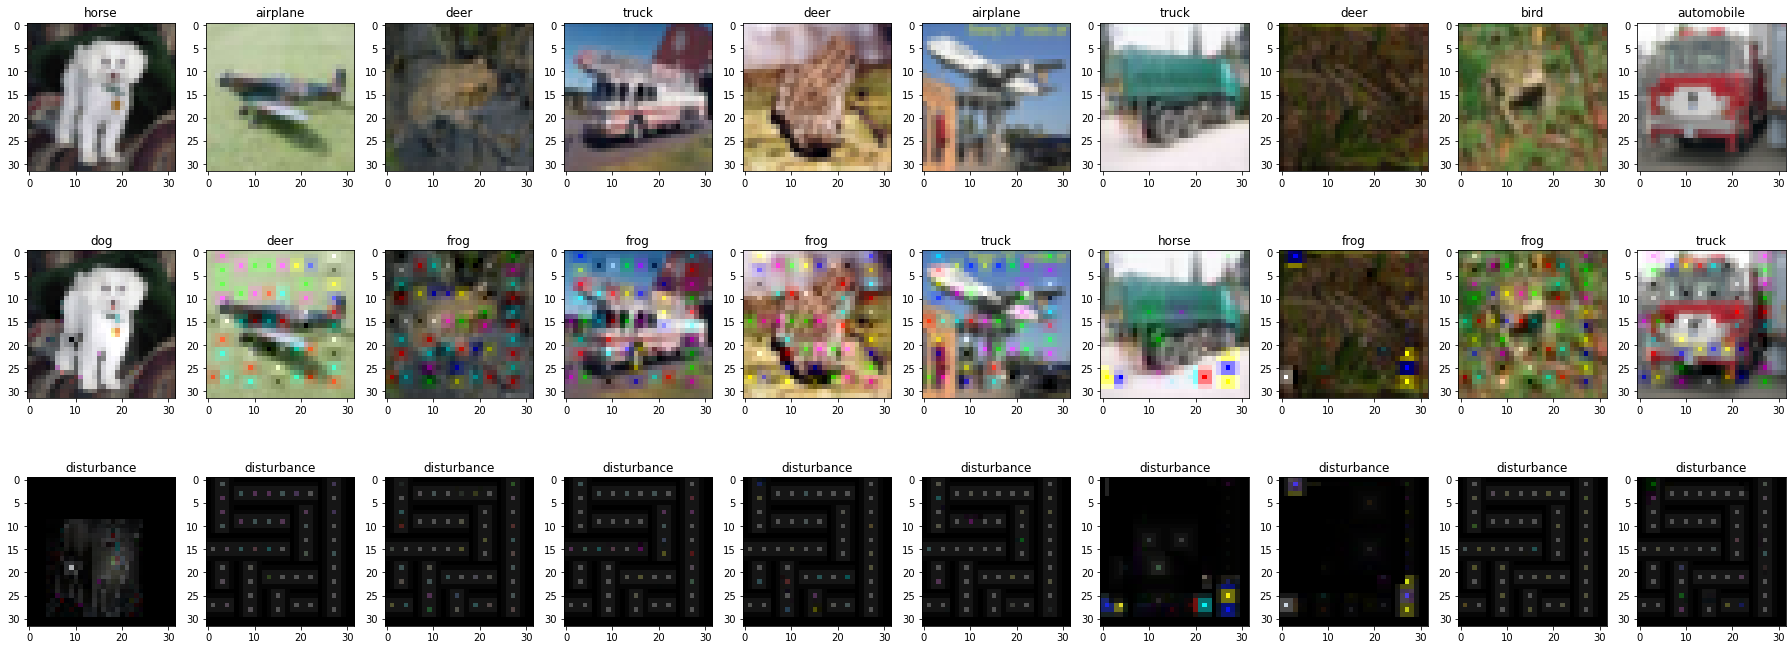

In [15]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.2 L-infinite attack

In [16]:
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=1000, eps=0.05, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [17]:
x_test_adv = attack.generate(x=x_test_10_ori)

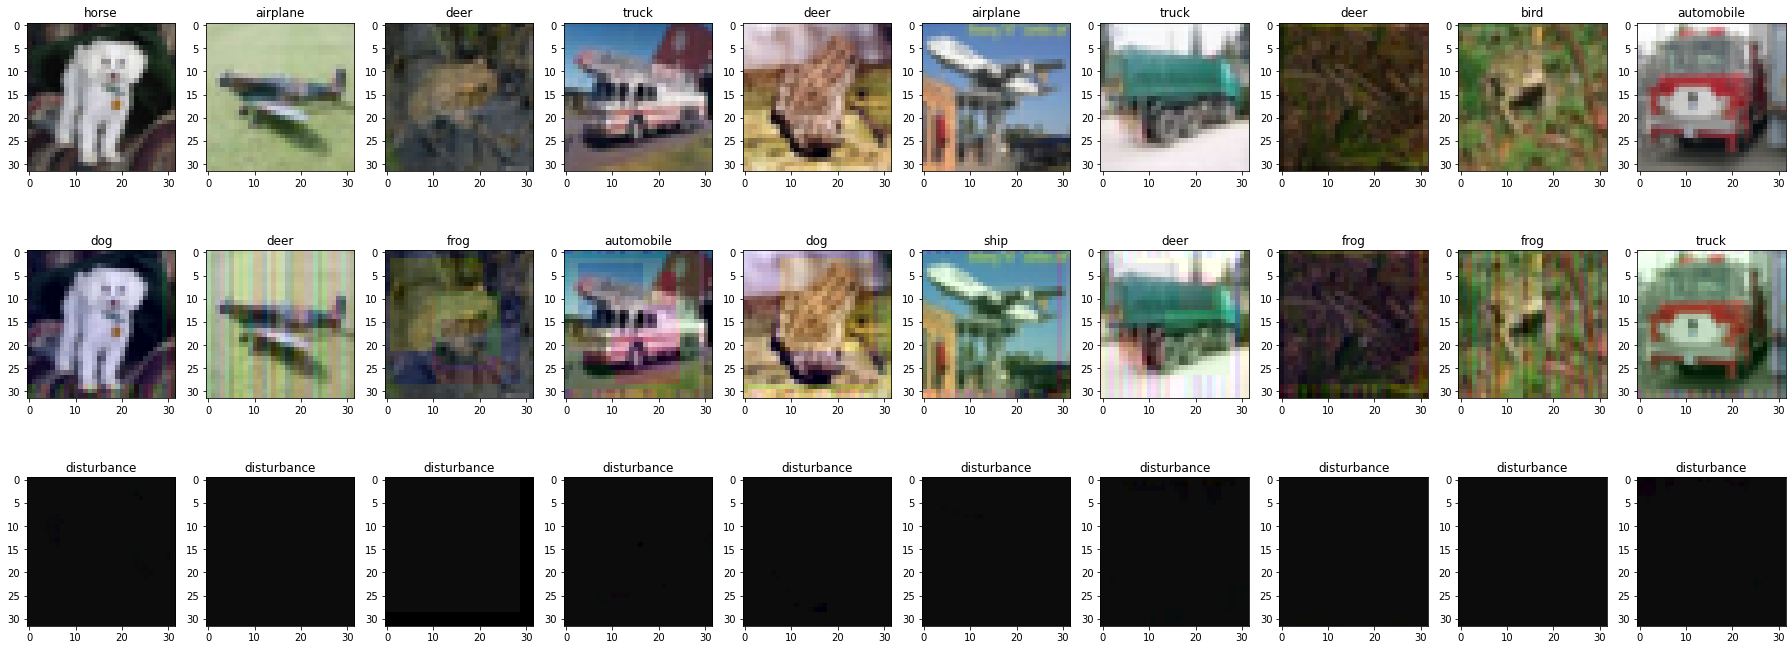

In [18]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.3 Test different Parameters with 100 random examples

In [19]:
with open ('./information/VGG19.txt', 'a') as f:
    f.write("Test Untargeted attack accuracy:\n")



for norm in [2, np.inf]:
  for eps in [0.05, 3, 5]:
    for p_init in [0.0125, 0.025, 0.05, 0.1, 0.2, 0.4]:
      attack = SquareAttack(estimator=classifier, norm=norm, max_iter=1000, eps=eps, p_init=p_init, nb_restarts=1, verbose=False)

      x_test_adv = attack.generate(x=x_test_100_ori)

      predictions_adv = classifier.predict(x_test_adv)
      predictions_ori = classifier.predict(x_test_100_ori)

      accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
      accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

      print(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%, finish time: {datetime.now()}\n")

      with open ('./information/VGG19.txt', 'a') as f:
        f.write(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%\n")

/home/users/vo836354/.conda/envs/CPU/lib/python3.10/site-packages/art/attacks/evasion/square_attack.py:475: RuntimeWarning: divide by zero encountered in true_divide
  delta_new /= np.sqrt(np.sum(delta_new ** 2, axis=(1, 2), keepdims=True)) * np.sqrt(
/home/users/vo836354/.conda/envs/CPU/lib/python3.10/site-packages/art/attacks/evasion/square_attack.py:475: RuntimeWarning: invalid value encountered in true_divide
  delta_new /= np.sqrt(np.sum(delta_new ** 2, axis=(1, 2), keepdims=True)) * np.sqrt(


norm: 2, eps: 0.05, p_init: 0.0125, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 59.0%, finish time: 2022-07-31 13:21:17.776881

norm: 2, eps: 0.05, p_init: 0.025, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-07-31 13:37:55.047775

norm: 2, eps: 0.05, p_init: 0.05, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 59.0%, finish time: 2022-07-31 13:53:57.529922

norm: 2, eps: 0.05, p_init: 0.1, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 59.0%, finish time: 2022-07-31 14:10:11.577818

norm: 2, eps: 0.05, p_init: 0.2, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 60.0%, finish time: 2022-07-31 14:26:17.807459

norm: 2, eps: 0.05, p_init: 0.4, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 59.0%, finish time: 2022-07-31 14:42:21.956928

norm: 2, eps: 3, p_init: 0.0125, Accuracy before attack: 57.99999999999999%, Accuracy after a

## 3.2 Test Target Attack

In [20]:
def generate_random_target(ori_target, classes_num):
  class_y_test = np.argmax(ori_target, axis=1)
  nb_classes = np.unique(class_y_test).shape[0]
  targets = np.random.randint(nb_classes, size=len(ori_target))
  for i in range(len(ori_target)):
      if class_y_test[i] == targets[i]:
          targets[i] -= 1

  targets = tf.one_hot(targets, classes_num)

  return targets

##### 2.2.2.1 Use 10 samples for showing difference and effects

In [21]:
targets = generate_random_target(y_test_10, 10)

### 3.1.1 L2 attack

In [22]:
attack = SquareAttack(estimator=classifier, norm=2, max_iter=1000, eps=5, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [23]:
x_test_adv = attack.generate(x=x_test_10_ori, y=targets)

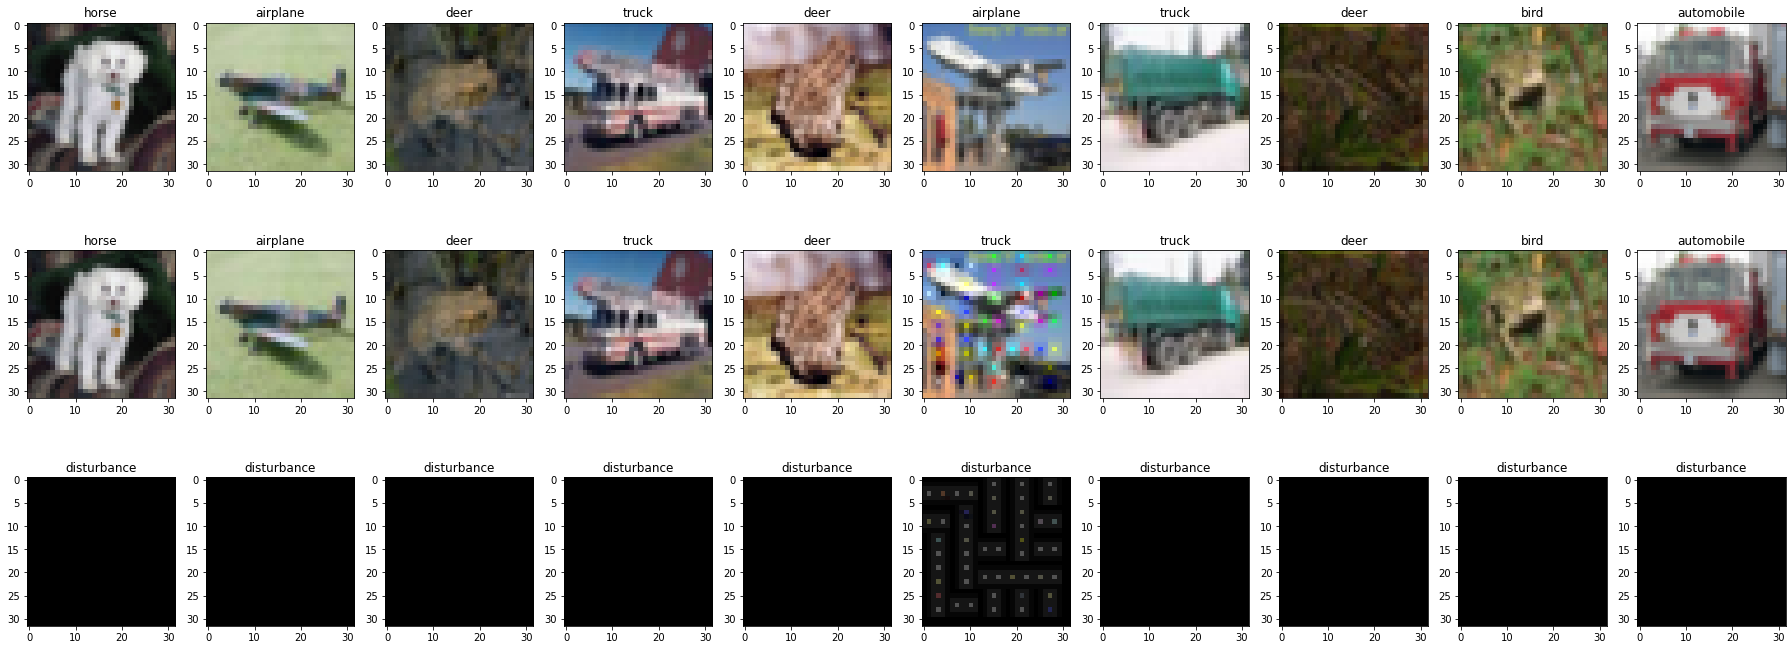

In [24]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.2 L-infinite attack

In [25]:
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=1000, eps=0.05, p_init=0.8, nb_restarts=1, verbose=False)

Use 10 samples for showing difference and effects

In [26]:
x_test_adv = attack.generate(x=x_test_10_ori, y=targets)

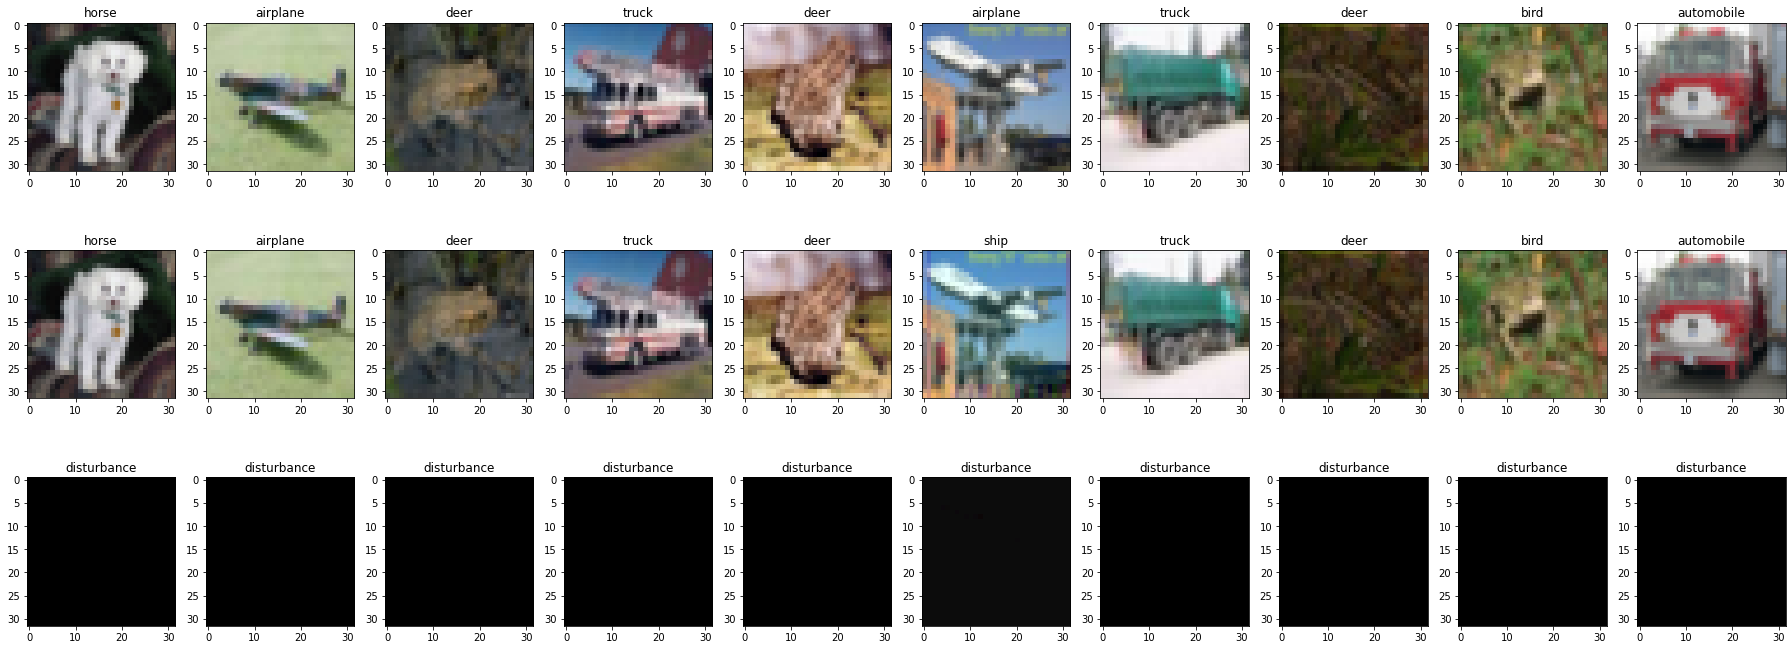

In [27]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

  
  

### 3.1.3 Test different Parameters with 100 random examples

In [28]:
with open ('./information/VGG19.txt', 'a') as f:
  f.write("Test targeted attack accuracy:\n")


for norm in [2, np.inf]:
  for eps in [0.05, 3, 5]:
    for p_init in [0.0125, 0.025, 0.05, 0.1, 0.2, 0.4]:

      if norm==2:
        max_iter=60000;
      else:
        max_iter=100000;

      attack = SquareAttack(estimator=classifier, norm=norm, max_iter=max_iter, eps=eps, p_init=p_init, nb_restarts=1, verbose=False)

      targets = generate_random_target(y_test_100, 100)

      x_test_adv = attack.generate(x=x_test_100_ori, y=targets)

      predictions_adv = classifier.predict(x_test_adv)
      predictions_ori = classifier.predict(x_test_100_ori)

      accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)
      accuracy_ori = np.sum(np.argmax(predictions_ori, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

      print(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%, finish time: {datetime.now()}\n")

      with open ('./information/VGG19.txt', 'a') as f:
        f.write(f"norm: {norm}, eps: {eps}, p_init: {p_init}, Accuracy before attack: {accuracy_ori * 100}%, Accuracy after attack: {accuracy_adv * 100}%\n")

norm: 2, eps: 0.05, p_init: 0.0125, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-07-31 23:27:34.221144

norm: 2, eps: 0.05, p_init: 0.025, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-08-01 06:50:19.428408

norm: 2, eps: 0.05, p_init: 0.05, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-08-01 14:24:45.158925

norm: 2, eps: 0.05, p_init: 0.1, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-08-01 22:33:21.411131

norm: 2, eps: 0.05, p_init: 0.2, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-08-02 07:34:07.624664

norm: 2, eps: 0.05, p_init: 0.4, Accuracy before attack: 57.99999999999999%, Accuracy after attack: 57.99999999999999%, finish time: 2022-08-02 15:47:16.223766

norm: 2, eps: 3, p_init: 0.0